In [1]:
library('ggplot2')
library('plyr')
library('lattice')
library('parallel')
source('ss_analysis.R')
stopwords = read.csv('data/function_words/functionWords.csv', stringsAsFactors=F)
plurals = read.csv('data/plurals/plurals.csv', stringsAsFactors=F)

Loading required package: RJSONIO

Attaching package: 'reshape'

The following objects are masked from 'package:plyr':

    rename, round_any

Loading required package: fit.models
Loading required package: MASS
Loading required package: robustbase
Loading required package: rrcov
Scalable Robust Estimators with High Breakdown Point (version 1.3-11)



In [2]:
oed = read.csv('data/OED/wordforms_combined.csv', stringsAsFactors=F)
df_gb12_en_new = read.csv('results/GoogleBooks2012/eng-all/00_lexicalSurprisal/opus_meanSurprisal.csv', stringsAsFactors=F)
df_gb12_en_new_sublex = read.csv('results/GoogleBooks2012/eng-all/01_sublexicalSurprisal/25000_sublex.csv', stringsAsFactors=F)
df_gb12_m1 = merge(df_gb12_en_new, df_gb12_en_new_sublex, by='word')
df_gb12_m1$logFrequency = log(df_gb12_m1$frequency)
df_gb12_m1$unigramSurprisal = -1 *log(df_gb12_m1$frequency/sum(df_gb12_m1$frequency, na.rm=T))
gb2012_swbd_dates = merge(df_gb12_m1, oed, by='word')
gb2012_swbd_dates = subset(gb2012_swbd_dates, !is.infinite(ipa_ss) & !is.infinite(unigramSurprisal))
gb2012_swbd_dates$yearMod  = sapply(gb2012_swbd_dates$year, function(x){ifelse(x<700, 700, x)})
gb2012_swbd_dates = subset(gb2012_swbd_dates, !(word %in% stopwords$word) & !(word %in% plurals$word))
gb2012_swbd_dates$century = ceiling(gb2012_swbd_dates$year / 100) *100 -100

In [3]:
print(getCorsForDataset(gb2012_swbd_dates))
print(getCorsForDataset(gb2012_swbd_dates, robust=T))

    uniSurp   triSurp     sm
1 0.1678090 0.2010341  ipa_n
2 0.4011361 0.3429785 ipa_ss
    uniSurp   triSurp     sm
1 0.1537793 0.1941184  ipa_n
2 0.3503003 0.3221129 ipa_ss


In [4]:
# choose words in the analysis
targetDataset = subset(gb2012_swbd_dates, century >= 800)

# build a table of Spearman's rank correlation coefficients
numformat <- function(val) { gsub("0\\.", ".", as.character(sprintf("%.2f", val))) }
get_spearman_cors = function(df){
  sp_ipa_ss_trigramSurprisal = cor(df$ipa_ss, df$mean_surprisal_weighted, method='spearman', use='pairwise.complete.obs')
  sp_ipa_ss_logFrequency = cor(df$ipa_ss, df$logFrequency, method='spearman', use='pairwise.complete.obs') 
  sp_ipa_n_trigramSurprisal = cor(df$ipa_n,df$mean_surprisal_weighted, method='spearman', use='pairwise.complete.obs')  
  sp_ipa_n_logFrequency = cor(df$ipa_n,df$logFrequency, method='spearman', use='pairwise.complete.obs')
  rdf = data.frame(
      century= unique(df$century),
      sp_ipa_ss_trigramSurprisal,
      sp_ipa_ss_logFrequency,
      sp_ipa_n_trigramSurprisal,
      sp_ipa_n_logFrequency,
       n=nrow(df))
  for (colname in c('sp_ipa_ss_trigramSurprisal','sp_ipa_ss_logFrequency','sp_ipa_n_trigramSurprisal','sp_ipa_n_logFrequency')){ 
      rdf[[paste0(colname,'_str')]] = numformat(rdf[[colname]])
  }    
  return(rdf)  
}
spears <- do.call('rbind', lapply(split(targetDataset,targetDataset$century),get_spearman_cors))

# get a count of types per century, merge it into the correlations table
centuryCount = ddply(targetDataset, .(century), nrow)
names(centuryCount) = c('century','wordCount')
spears = merge(spears, centuryCount, by='century') 

#get the century-n into the target dataset 
targetDataset = merge(targetDataset, centuryCount, by='century')
targetDataset$centuriesInLanguage = (2000 - targetDataset$century)/100

#create labels for the correlations and the 
spears$century_n = paste0('n=',spears$wordCount)
targetDataset$century_n = paste0(targetDataset$century,' (',targetDataset$wordCount, ')')

In [5]:
targetDataset$residual_ipa_ss = lm(ipa_ss ~ ipa_n, targetDataset)$residual
targetDataset$residual_ipa_n = lm(ipa_n ~ ipa_ss, targetDataset)$residual
targetDataset$centuriesInLanguage = (2000 - targetDataset$century)/100

In [6]:
targetDataset$residual_ipa_ss_freq = lm(ipa_ss ~ logFrequency, targetDataset)$residual
targetDataset$residual_ipa_n_freq = lm(ipa_n ~ logFrequency, targetDataset)$residual

In [7]:
by_century = split(targetDataset, targetDataset$century)

In [8]:
bootstrappedCI = function(df, param1, param2, numIter, method='spearman'){
    corrs = mat.or.vec(1,numIter)
    for (i in 1:numIter){
        sampleIndices = sample(1:nrow(df), nrow(df), replace=T)
        ndf =df[sampleIndices,]         
        corrs[i] = cor(ndf[[param1]], ndf[[param2]] , method, use='pairwise.complete.obs')
    }        
    return(corrs)    
}

In [9]:
length_cis = do.call('rbind', mclapply(by_century, function(df){
    corrs = bootstrappedCI(df, 'ipa_n','unigramSurprisal', 1000, method='spearman')
    ci = quantile(corrs, probs=c(.005, .995))
    data.frame(length_low=ci[1], length_high=ci[2], century=unique(df$century), measure='spearman', stringsAsFactors=F)
    
}, mc.cores=24))

In [10]:
ss_cis = do.call('rbind', mclapply(by_century, function(df){
    corrs = bootstrappedCI(df, 'ipa_ss','unigramSurprisal', 1000, method='spearman')
    ci = quantile(corrs, probs=c(.005, .995))
    data.frame(ss_low=ci[1], ss_high=ci[2], century=unique(df$century), measure='spearman', stringsAsFactors=F)
    
}, mc.cores=24))

In [11]:
spears_aug = merge(merge(spears, length_cis), ss_cis)
#library('reshape2')
spears_long = melt(spears_aug,c('century','n','wordCount', 'century_n','measure'))

In [12]:
spears_long$value = as.numeric(spears_long$value)
spears_long[1:3,]
spears_means = subset(spears_long, variable %in% c('sp_ipa_ss_logFrequency', 'sp_ipa_n_logFrequency'))
spears_means$variable = factor(as.character(spears_means$variable), levels=c('sp_ipa_ss_logFrequency', 'sp_ipa_n_logFrequency'))

century,n,wordCount,century_n,measure,variable,value
1000,1061,1061,n=1061,spearman,sp_ipa_ss_trigramSurprisal,0.3660660
1100,340,340,n=340,spearman,sp_ipa_ss_trigramSurprisal,0.3636184
1200,1680,1680,n=1680,spearman,sp_ipa_ss_trigramSurprisal,0.3307012


In [13]:
names(ss_cis) = c('low','high','century','measure')
ss_cis$variable = 'sp_ipa_ss_logFrequency'
names(length_cis) = c('low','high','century','measure')
length_cis$variable = 'sp_ipa_n_logFrequency'
cis = rbind(ss_cis, length_cis)
cis$low = as.numeric(cis$low)
cis$high = as.numeric(cis$high)
cis$variable = factor(as.character(cis$variable), levels=c('sp_ipa_ss_logFrequency', 'sp_ipa_n_logFrequency'))

png 
  2

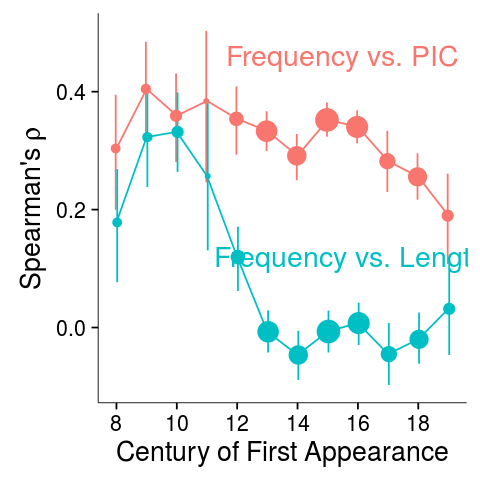

In [16]:
options(repr.plot.width=4, repr.plot.height=4, jupyter.plot_mimetypes = 'image/png')
dodge <- position_dodge(width=10) 
histPlot_CI = ggplot() + geom_linerange(data=cis, aes(x=century, ymin=low, ymax=high, colour=variable), position=dodge) + geom_line(
    data = spears_means, aes(y= -1*value,x=century, colour=variable)) + geom_point(data = spears_means,
    aes(y= -1*value,x=century,size=n, colour=variable), position=dodge) + theme_bw(base_size = 16) + xlab('Century of First Appearance'
) + ylab(expression(paste("Spearman's ",rho))) +theme(legend.position="none") + scale_x_continuous(
    breaks = seq(from=800,to=2000, by=200), labels=as.character(seq(from=8,to=20, by=2)))  +theme(
    axis.line.x = element_line(color="black", size = .25),
    axis.line.y = element_line(color="black", size = .25),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    panel.border = element_blank(),
    panel.background = element_blank()
) + annotate("text",x=1550, y=.46,label='Frequency vs. PIC', size=6, colour = '#F8766D' 
) + annotate("text",x=1575, y=.12,label='Frequency vs. Length', size=6, colour="#00BFC4")

pdf('figures/histPlot_CIs.pdf', height=4, width=6)
print(histPlot_CI)
dev.off()
histPlot_CI